 # Module 7 - Differential Expression Analysis of bulk RNA-Seq
 In this notebook, we will be showing and example differential expression analysis using the pydeseq2 package.

 `pydeseq2` is a python implementation for the popular R package `DESeq2` for differential analysis of **raw** count data from bulk RNA-Seq experiments.

 We will be using the following tools/packages:

 - [`pydeseq2`](https://pydeseq2.readthedocs.io/en/latest/) for differential expression analysis
 - [`anndata`](https://anndata.readthedocs.io/en/latest/) for data wrangling and to generate the base object required by `pydeseq2`
 - [`scanpy`](https://scanpy.readthedocs.io/en/latest/) for select visualizations of the pydesq2 object
 - [`plotnine`](https://plotnine.readthedocs.io/en/latest/) for other visualizations
 - [`seaborn`](https://seaborn.readthedocs.io/en/latest/) for heatmap (clustermap) visualizations
 - `pandas` and `numpy` for data wrangling

  Much of the code in this notebook is adapted from the official [pydeseq2 'Step-by-step' workflow](https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_step_by_step.html#sphx-glr-auto-examples-plot-step-by-step-py).

 First, let's install the required packages

 ## Install required packages
 You will only need to run this cell once!

 Here we are also using pip to install the most recent version of scanpy from github.

In [1]:
%%bash
#mamba install -c bioconda pydeseq2 leidenalg seaborn anndata
#pip install git+https://github.com/scverse/scanpy


 Now we can import all of the required packages

In [2]:
import pandas as pd
import numpy as np
import plotnine as pn
import seaborn as sns

import anndata as ad

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scanpy as sc


 ## Load Data
 The three required input files for this analysis are provided in the `data` directory.

 PyDESeq2 can use either the raw count matrix and the metadata table, or (more conveniently) an `anndata` object containing all of the feature (`adata.var`) and sample information (`adata.obs`) as well as the count matrix (`adata.X`).

 We are going to load each of the three required matrices using `pandas.read_csv`

In [3]:
counts = pd.read_csv("data/mamgland_counts.txt",index_col=0)
sampleData = pd.read_csv("data/mamgland_colData.txt",index_col=0)
geneData = pd.read_csv("data/mamgland_rowData.txt",index_col=0)


 Let's take a quick look at each of the matrices to make sure they were imported and formatted correctly.

In [4]:
counts.head()


,10_6_5_11,9_6_5_11,purep53,JMS8-2,JMS8-3,JMS8-4,JMS8-5,JMS9-P7c,JMS9-P8c
497097,1,2,342,526,3,3,535,2,0
100503874,0,0,5,6,0,0,5,0,0
100038431,0,0,0,0,0,0,1,0,0
19888,0,1,0,0,17,2,0,1,0
20671,1,1,76,40,33,14,98,18,8


In [5]:
sampleData.head()


,files,group,filenam,lane
10_6_5_11,data/GSM1545535_10_6_5_11.txt,LP,GSM1545535_10_6_5_11,L004
9_6_5_11,data/GSM1545536_9_6_5_11.txt,ML,GSM1545536_9_6_5_11,L004
purep53,data/GSM1545538_purep53.txt,Basal,GSM1545538_purep53,L004
JMS8-2,data/GSM1545539_JMS8-2.txt,Basal,GSM1545539_JMS8-2,L006
JMS8-3,data/GSM1545540_JMS8-3.txt,ML,GSM1545540_JMS8-3,L006


In [6]:
geneData.head()


,rownames,ENTREZID,SYMBOL,TXCHROM
497097,1,497097,Xkr4,chr1
100503874,2,100503874,Gm19938,NaN
100038431,3,100038431,Gm10568,NaN
19888,4,19888,Rp1,chr1
20671,5,20671,Sox17,chr1


 Because the counts matrix is being provided as a `genesXsamples` matrix, we need to transpose it to a `samplesXgenes` matrix to create an `anndata` object.


In [7]:
# Transpose the count matrix to samples x genes
counts = counts.T


 Now that we have the required matrices, we can create the `anndata` object `adata`

In [8]:
adata = ad.AnnData(X=counts,obs=sampleData,var=geneData)


/home/lgoff2/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.


In [9]:
adata


AnnData object with n_obs × n_vars = 9 × 27179
    obs: 'files', 'group', 'filenam', 'lane'
    var: 'rownames', 'ENTREZID', 'SYMBOL', 'TXCHROM'

 Subset `adata` to only include the samples we want to compare (['Basal','LP'])

In [10]:
adata = adata[adata.obs['group'].isin(['Basal','LP'])].copy()


 ## Read counts modeling
 Read counts modeling with the DeseqDataSet class

The DeseqDataSet class takes one required positional argument (the `anndata` object), as well as a set of optional keyword arguments, including:

 - design_factor: the name of the column of metadata to be used as a design variable

 - refit_cooks: whether to refit cooks outliers – this is advised, in general.

 We construct the DeseqDataSet object from `adata` and specify the design factor to be the `group` column of the metadata table, which contains the information about the sample groups (Basal, LP, and ML).

In [11]:
dds = DeseqDataSet(
    adata = adata,
    design_factors="group",  # compare samples based on the "condition"
    # column ("B" vs "A")
    refit_cooks=True,
    n_cpus=8,
)


In [12]:
dds


AnnData object with n_obs × n_vars = 6 × 27179
    obs: 'files', 'group', 'filenam', 'lane'
    var: 'rownames', 'ENTREZID', 'SYMBOL', 'TXCHROM'
    obsm: 'design_matrix'

 Notice that the `dds` object is actually an 'extended' `anndata` object, with all of the original data slots, accessors, methods, etc. The only difference is the addition of a few additional attributes and methods which will be used for the specific purpose of differential expression analysis.

 ## Some Basic QC
 Let's take a quick look at the data to make sure everything looks good.
 One of the ways we can do this is by performing a principal component analysis (PCA) and visualizing the results.

 PCA is a dimensionality reduction technique that is often used to visualize high-dimensional data. And can be useful to identify relationships between samples and/or groups of samples as well as identify potential outliers.

 We can use the `scanpy` package to perform the PCA and visualize the results. `scanpy` is a python package that is originally designed for single-cell RNA-Seq analysis, but can adopt some of the qc and visualization tools for bulk RNA-Seq data as well.


/home/lgoff2/miniforge3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


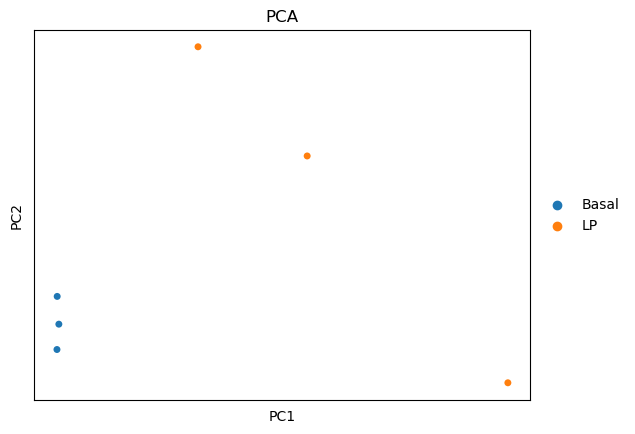

In [13]:
sc.tl.pca(dds)
sc.pl.pca(dds, color="group", title="PCA", s=100)

 ### Compute normalization factors

In [14]:
dds.fit_size_factors()
dds.obsm["size_factors"]


Fitting size factors...
... done in 0.01 seconds.



array([0.6998475 , 1.44614589, 1.25611068, 1.32597858, 1.3053295 ,
       0.46535262])

 ### Fit gene-wise dispersions

In [15]:
dds.fit_genewise_dispersions()
dds.varm["genewise_dispersions"]


Fitting dispersions...
... done in 4.42 seconds.



array([1.00000068e-08, 1.00000000e-08, 1.00000000e-08, ...,
       4.99421276e-02,            nan,            nan])

 ### Fit dispersion trend coefficients

In [16]:
dds.fit_dispersion_trend()
dds.uns["trend_coeffs"]
dds.varm["fitted_dispersions"]


Fitting dispersion trend curve...
... done in 4.98 seconds.



array([ 0.06023023,  1.9261951 , 29.76006973, ...,  0.04319424,
               nan,         nan])

 ### Dispersion priors

In [17]:
dds.fit_dispersion_prior()
print(
    f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
)


logres_prior=1.1422605401645616, sigma_prior=0.49732647331633495


 ### MAP Dispersions
 The `fit_MAP_dispersions` method filters the genes for which dispersion shrinkage is applied.

 Indeed, for genes whose MLE dispersions are too high above the trend curve, the original MLE value is kept.

 The final values of the dispersions that are used for downstream analysis is stored in dds.dispersions.

In [18]:
dds.fit_MAP_dispersions()
dds.varm["MAP_dispersions"]
dds.varm["dispersions"]


Fitting MAP dispersions...
... done in 5.06 seconds.



array([ 0.07000983,  1.35768875, 10.        , ...,  0.04645209,
               nan,         nan])

 Next we can check to make sure that the variance is stabilized appropriately.

 The `plot_dispersions` method plots the estimated, shrunken, and fitted dispersion values against the mean of normalized counts.

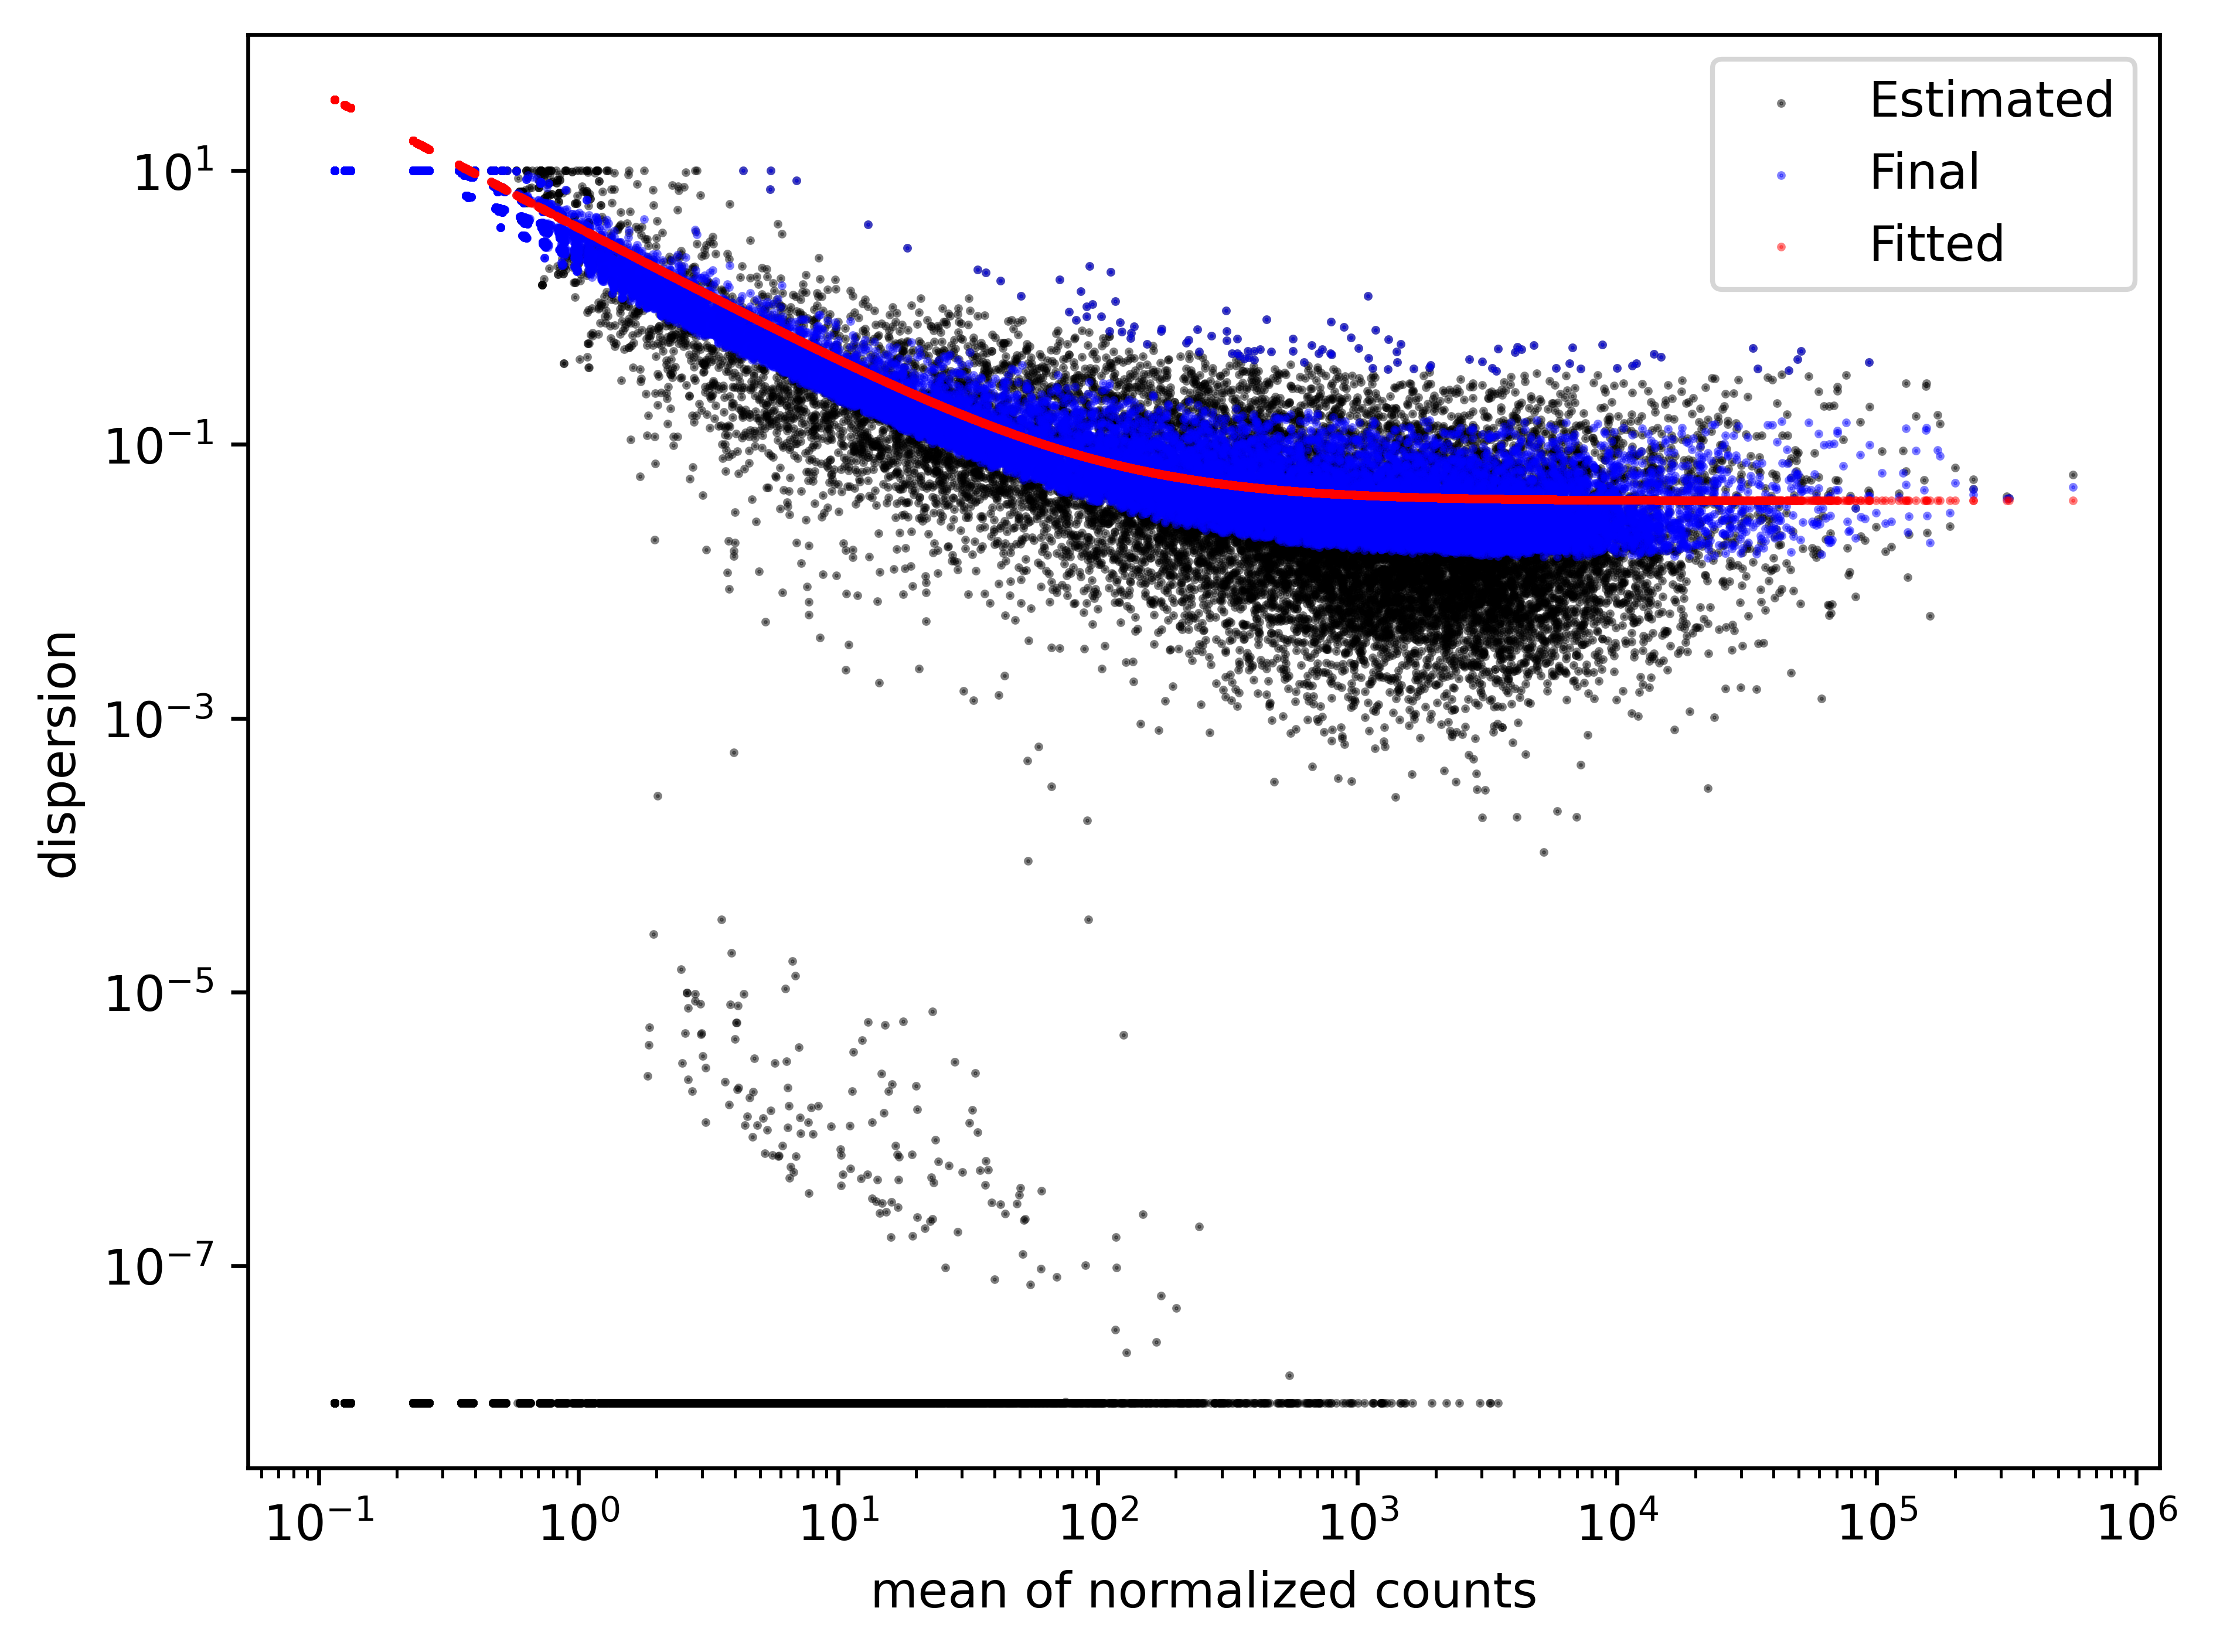

In [19]:
dds.plot_dispersions()


 ### Fit log fold changes
 Note that in the DeseqDataSet object, the log-fold changes are stored in natural log scale, but that the results dataframe output by the summary method of DeseqStats displays LFCs in log2 scale (see later on).


In [20]:
dds.fit_LFC()
dds.varm["LFC"]


Fitting LFCs...
... done in 2.97 seconds.



,intercept,group_LP_vs_Basal
497097,5.871818,-5.416670
100503874,1.390792,-2.804036
100038431,-1.314268,-0.098978
19888,-1.980926,1.554047
20671,3.973592,-1.736730
...,...,...
100861837,5.860231,-0.084276
100861924,3.686845,-1.015899
170942,6.734436,0.109060
100861691,NaN,NaN


 ### Calculate Cooks distances and refit
 Note that this step is optional.

In [21]:
dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()


Refitting 0 outliers.



## Statistical analysis
Statistical analysis with the DeseqStats class. We will create an instance of `DeseqStats` called `stat_res` and pass the `dds` object to it.

This object is responsible for performing the statistical analysis and storing the results.

In addition to the required `dds` input, there are a few additional optional keyword arguments, including:

- alpha: the p-value and adjusted p-value significance threshold

- cooks_filter: whether to filter p-values based on cooks outliers

- independent_filter: whether to perform independent filtering to correct p-value trends.

In [22]:
stat_res = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)


 Let's inspect the `stat_res` object to see what it contains.

In [23]:
stat_res.design_matrix


,intercept,group_LP_vs_Basal
10_6_5_11,1,1
purep53,1,0
JMS8-2,1,0
JMS8-4,1,1
JMS8-5,1,0
JMS9-P8c,1,1


In [24]:
stat_res.contrast


['group', 'LP', 'Basal']

In [25]:
stat_res.contrast_vector


array([0., 1.])

In [26]:
stat_res.LFC


,intercept,group_LP_vs_Basal
497097,5.871818,-5.416670
100503874,1.390792,-2.804036
100038431,-1.314268,-0.098978
19888,-1.980926,1.554047
20671,3.973592,-1.736730
...,...,...
100861837,5.860231,-0.084276
100861924,3.686845,-1.015899
170942,6.734436,0.109060
100861691,NaN,NaN


 A few additional slots will be filled after the statistical analysis is performed, including:
 - p_values: the p-values of the Wald tests
 - padj: the adjusted p-values
 - statistics: the Wald test statistics

 And a few others.  For now, let's use `stat_res` to actually perform the statistical analysis.

 ### Wald tests
 In bulk RNA-Seq with the DESeq2 workflow, the Wald test evaluates the probability of the null hypothesis that the log fold change between two conditions is equal to 0.

 In `pydeseq2`, the Wald test is performed by the `run_wald_test` method of the `DeseqStats` class (in our case, the instance `stat_res`).

In [27]:
stat_res.run_wald_test()
stat_res.p_values


Running Wald tests...
... done in 6.09 seconds.



497097       1.238583e-22
100503874    8.701925e-02
100038431    9.743288e-01
19888        6.083331e-01
20671        6.306546e-05
                 ...     
100861837    7.181446e-01
100861924    8.176920e-02
170942       5.406685e-01
100861691             NaN
100504472             NaN
Length: 27179, dtype: float64

 ### Cook's filtering
 Note: this step is optional

 Cook's filtering is used in this context to remove genes with extreme counts that may be driving the results.

 The `_cooks_filtering` method of the `DeseqStats` class performs Cook's filtering by removing genes with Cook's distance above a certain threshold.

In [28]:
if stat_res.cooks_filter:
    stat_res._cooks_filtering()


 Now that we've performed the Wald test and Cook's filtering, we actually have raw p-values associated with the Wald test statistics for each gene.

In [29]:
stat_res.p_values


497097       1.238583e-22
100503874    8.701925e-02
100038431    9.743288e-01
19888        6.083331e-01
20671        6.306546e-05
                 ...     
100861837    7.181446e-01
100861924    8.176920e-02
170942       5.406685e-01
100861691             NaN
100504472             NaN
Length: 27179, dtype: float64

 ### P-value adjustment
 Because we have performed a large number of statistical tests (one for each gene), we need to adjust the p-values to account for multiple testing.

 The `_p_value_adjustment` method of the `DeseqStats` class performs the p-value adjustment.

In [30]:
stat_res._p_value_adjustment()


 The results of the p-value adjustment are stored in the `padj` attribute of the `stat_res` object.


In [31]:
stat_res.padj


497097       1.875625e-21
100503874    1.708334e-01
100038431    9.856704e-01
19888        7.716488e-01
20671        2.535973e-04
                 ...     
100861837    8.441417e-01
100861924    1.620556e-01
170942       7.151630e-01
100861691             NaN
100504472             NaN
Length: 27179, dtype: float64

 ### Building a results dataframe
 To put this all together into something more easily interpretable, we can build a results dataframe that contains the results of our statistical analysis.

 The results_df attribute of the DeseqStats class can store this dataframe once it's been generated.

 To generate this results dataframe, we have to first make a call to the `summary()` method of the DeseqStats class.

In [32]:
stat_res.summary()


Log2 fold change & Wald test p-value: group LP vs Basal


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
497097,178.132189,-7.814603,0.798194,-9.790357,1.238583e-22,1.875625e-21
100503874,2.010761,-4.045368,2.363867,-1.711335,8.701925e-02,1.708334e-01
100038431,0.127682,-0.142795,4.437441,-0.032180,9.743288e-01,9.856704e-01
19888,0.251387,2.242015,4.375055,0.512454,6.083331e-01,7.716488e-01
20671,31.442171,-2.505572,0.626231,-4.001037,6.306546e-05,2.535973e-04
...,...,...,...,...,...,...
100861837,335.956364,-0.121585,0.336856,-0.360940,7.181446e-01,8.441417e-01
100861924,26.972771,-1.465633,0.842070,-1.740512,8.176920e-02,1.620556e-01
170942,889.233567,0.157340,0.257174,0.611802,5.406685e-01,7.151630e-01
100861691,0.000000,NaN,NaN,NaN,NaN,NaN


 Let's store the summary output into it's own dataframe for easier access.

In [33]:
res = stat_res.results_df.copy()


 Now let's take a look a the p-value distribution to see if this looks appropriate

/home/lgoff2/miniforge3/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 29'. Pick better value with 'binwidth'.
/home/lgoff2/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 5539 rows containing non-finite values.


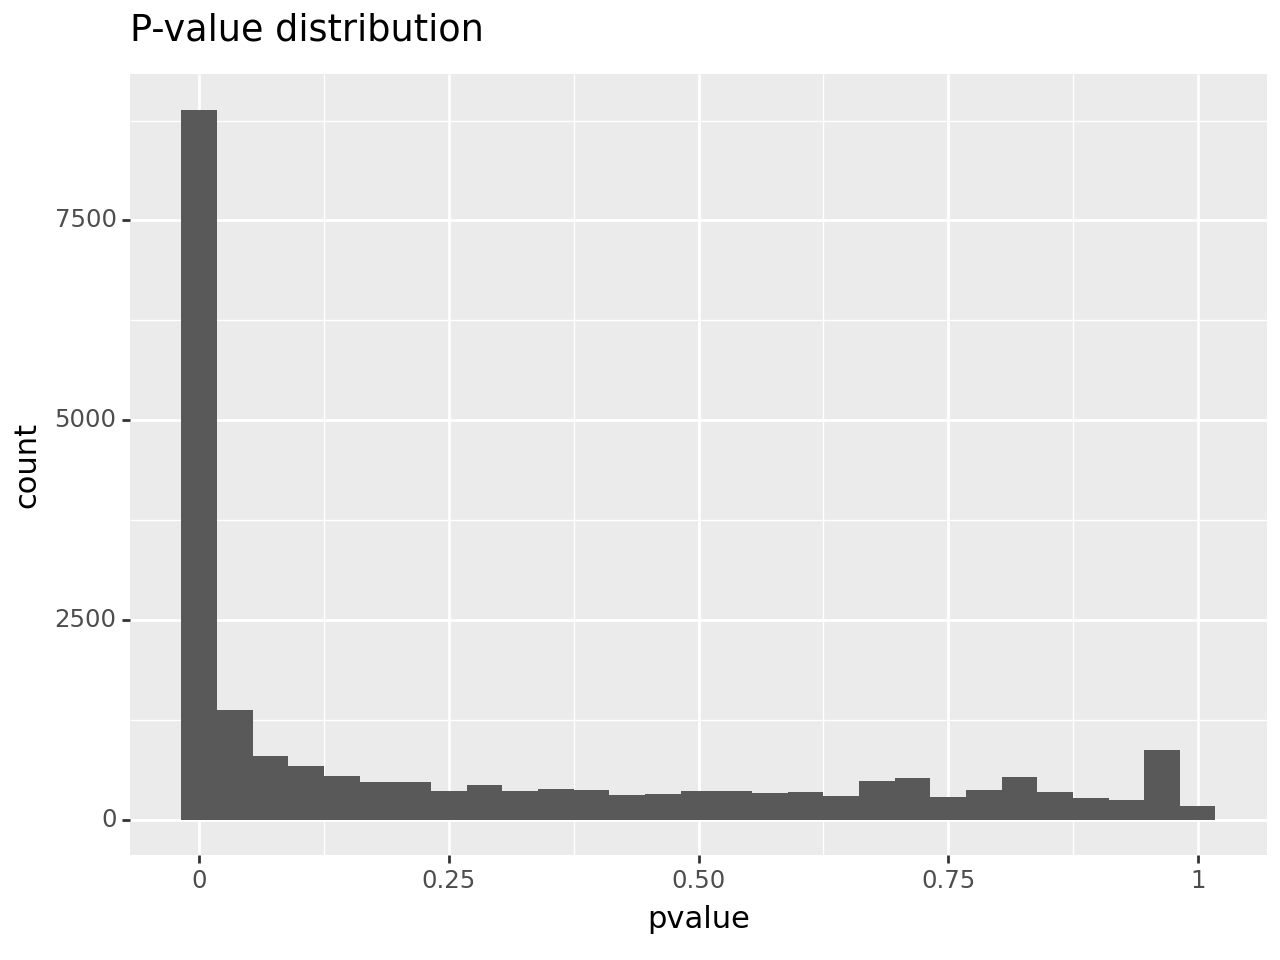

<Figure Size: (640 x 480)>

In [34]:
pval_hist = (
    pn.ggplot(stat_res.results_df, pn.aes(x="pvalue"))
    + pn.geom_histogram()
    + pn.ggtitle("P-value distribution")
)

pval_hist


 ### LFC Shrinkage
 For visualization or post-processing purposes, it might be suitable to perform LFC shrinkage. This is implemented by the lfc_shrink method.

In [35]:
stat_res.lfc_shrink(coeff="group_LP_vs_Basal")


Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: group LP vs Basal


... done in 5.83 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
497097,178.132189,-7.662522,0.770607,-9.790357,1.238583e-22,1.875625e-21
100503874,2.010761,-1.757931,2.618296,-1.711335,8.701925e-02,1.708334e-01
100038431,0.127682,-0.110327,1.134912,-0.032180,9.743288e-01,9.856704e-01
19888,0.251387,0.163911,2.768866,0.512454,6.083331e-01,7.716488e-01
20671,31.442171,-2.255469,0.636665,-4.001037,6.306546e-05,2.535973e-04
...,...,...,...,...,...,...
100861837,335.956364,-0.110018,0.327661,-0.360940,7.181446e-01,8.441417e-01
100861924,26.972771,-1.004089,0.806627,-1.740512,8.176920e-02,1.620556e-01
170942,889.233567,0.154135,0.253201,0.611802,5.406685e-01,7.151630e-01
100861691,0.000000,NaN,NaN,NaN,NaN,NaN


 ## Visualizations
 Let's explore some of our differential analysis results using some visualizations.

 First, we will make a volcano plot of the log2 fold change vs the -log10 adjusted p-value.

 We will use the shrunken LFCs for the x axis and a calculated -log10 `padj` for the y axis.

 Below, we are also choosing a p-value threshold of 1e-20 to highlight the most significant genes.

In [36]:
# Create a copy of the results dataframe to use for plotting
plot_data = stat_res.results_df.copy()

# Calculate the -log10 padj
plot_data["neg_log_10_padj"] = -np.log10(plot_data["padj"])

# Set a p-value threshold
pval_thres = 1e-20

# Add a column to indicate whether a particular gene test is significant or not
plot_data["significant"] = "Not significant"
plot_data["significant"][plot_data["padj"] <= pval_thres] = "Significant"


/tmp/ipykernel_1549461/3558278667.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 Now that we've prepared the plotting data, we can make the volcano plot using `plotnine`

/home/lgoff2/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 5539 rows containing missing values.


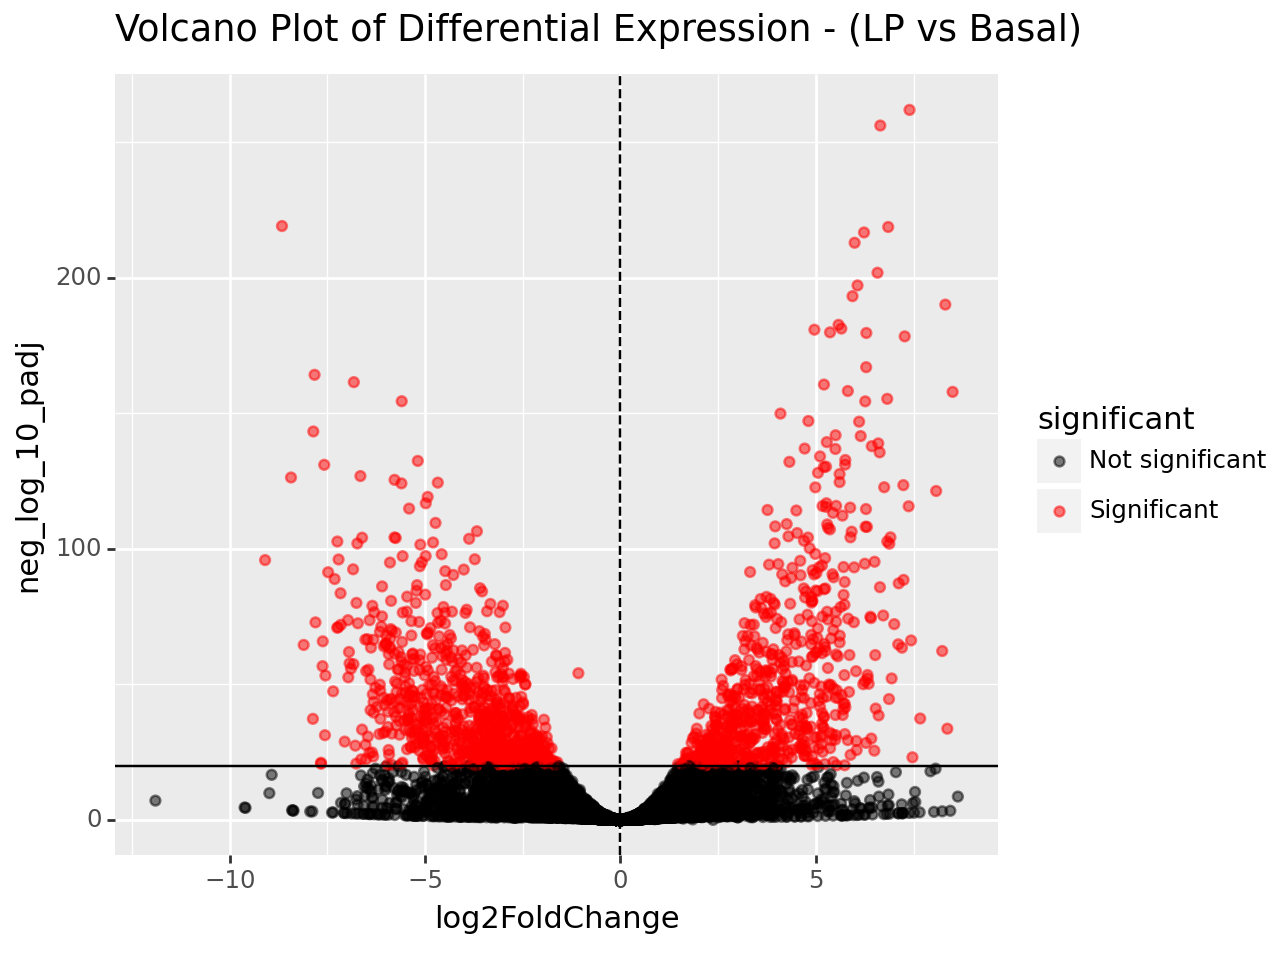

<Figure Size: (640 x 480)>

In [37]:
volcano_plot = (
    pn.ggplot(plot_data,pn.aes(x="log2FoldChange",y="neg_log_10_padj"))
    + pn.geom_point(pn.aes(color="significant"),alpha=0.5)
    + pn.geom_vline(xintercept=0,linetype="dashed")
    + pn.geom_hline(yintercept=-np.log10(pval_thres))
    + pn.scale_color_manual(values=["black","red"])
    + pn.ggtitle("Volcano Plot of Differential Expression - (LP vs Basal)")
)

volcano_plot


 Is there a relationship between mean expression and p-value? Let's investigate using a scatter plot.

/home/lgoff2/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/home/lgoff2/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 5539 rows containing missing values.


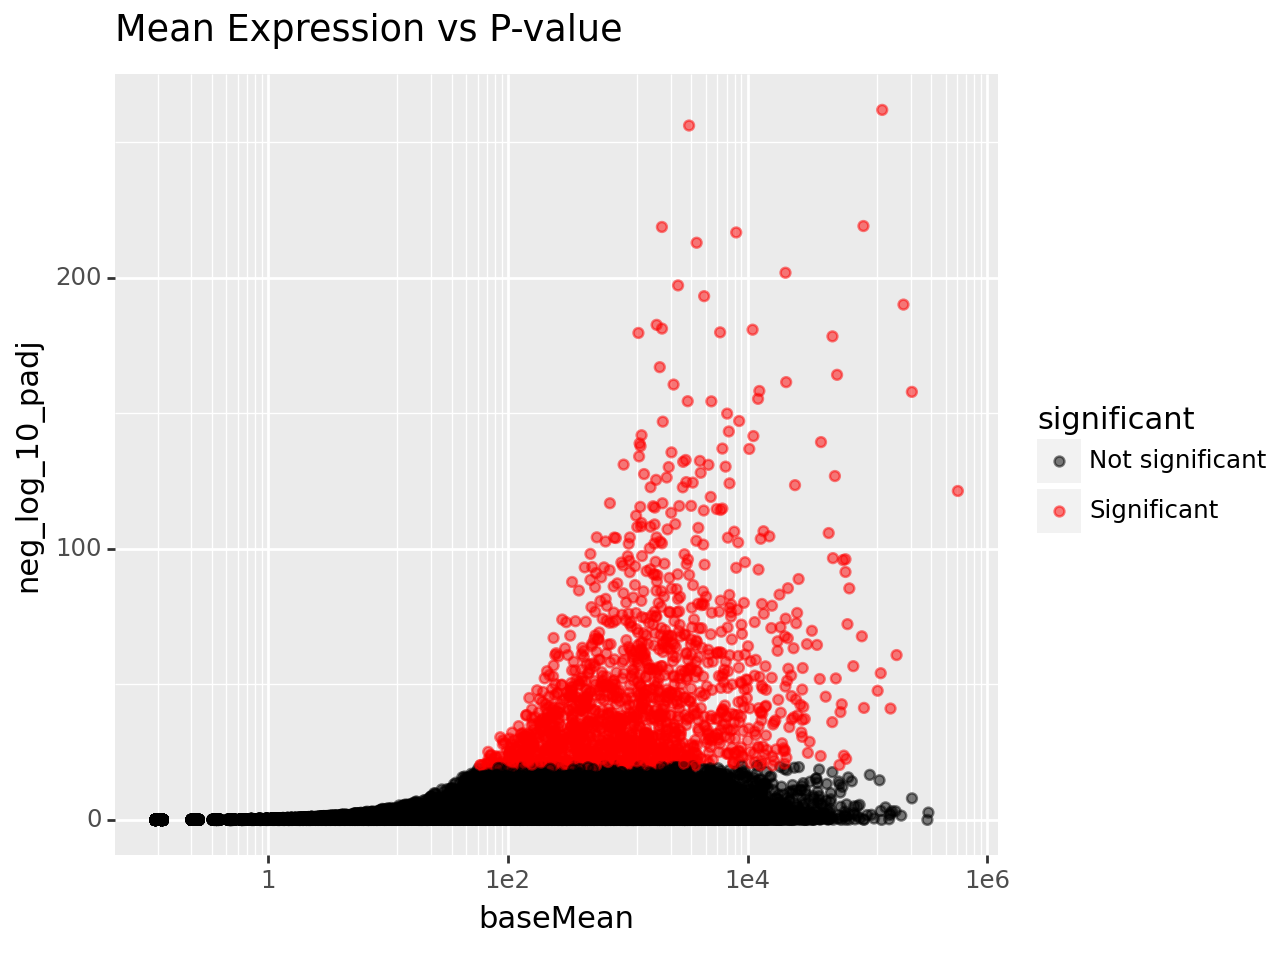

<Figure Size: (640 x 480)>

In [38]:
mean_v_pval_plot = (
    pn.ggplot(plot_data,pn.aes(x="baseMean",y="neg_log_10_padj"))
    + pn.geom_point(pn.aes(color="significant"),alpha=0.5)
    + pn.scale_color_manual(values=["black","red"])
    + pn.scale_x_log10()
    + pn.ggtitle("Mean Expression vs P-value")
)

mean_v_pval_plot


 ### Heatmap of significant genes
 Finally, let's take a subset of our significant genes and make a heatmap of the log1p normalized counts.

 Since we have a large number, we're going to subset using some fairly stringent criteria:
 - A very low adjusted pvalue (`padj` <= 1e-20)
 - A log fold change  > 0.5 (`log2FoldChange`)
 - Mean expression > 20 (`baseMean`)

 After applying these filters, we are going to identify the genes that meet these criteria, and create an index so that we can subset the original `dds` object to only include these genes.

 We will then use the `sns.clustermap` function to create a heatmap of the log1p normalized counts for these genes.

 First, lets create a new layer in `dds` that contains the log1p normalized counts.

In [39]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])


 Now, let's apply our filtering critera to the stat_res.results_df dataframe to identify the genes that meet our criteria.

In [40]:
sig_gene_df = stat_res.results_df[(stat_res.results_df['padj'] <= pval_thres) & (abs(stat_res.results_df["log2FoldChange"] > 0.5)) & (stat_res.results_df["baseMean"] > 20 )]


 `sig_gene_df` is a new results dataframe that only contains the genes that meet our criteria.

In [41]:
sig_gene_df.shape


(684, 6)

 Now we'll use the index of `sig_gene_df` (which contains the gene identifiers) to subset the `dds` object to only include the genes that meet our significance criteria.

In [42]:
dds_sig_genes = dds[:,sig_gene_df.index]


In [43]:
dds_sig_genes


View of AnnData object with n_obs × n_vars = 6 × 684
    obs: 'files', 'group', 'filenam', 'lane'
    var: 'rownames', 'ENTREZID', 'SYMBOL', 'TXCHROM'
    uns: 'pca', 'group_colors', 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'X_pca', 'size_factors'
    varm: 'PCs', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

 Now, we will take the `dds_sig_genes` object and create a new `wide` dataframe that contains the log1p normalized counts for each sample.

 This dataframe will have the shape (sigGenes X samples).

In [44]:
plot_data = pd.DataFrame(dds_sig_genes.layers['log1p'].T, index = dds_sig_genes.var["SYMBOL"], columns = dds_sig_genes.obs_names)


 And finally, we can use the seaborn `clustermap` function to create a heatmap of the log1p normalized counts for these genes.

 The argument `z_score=0` will normalize the rows (genes) to have a mean of 0 and a standard deviation of 1 to allow for easier visualization of the differences between samples.

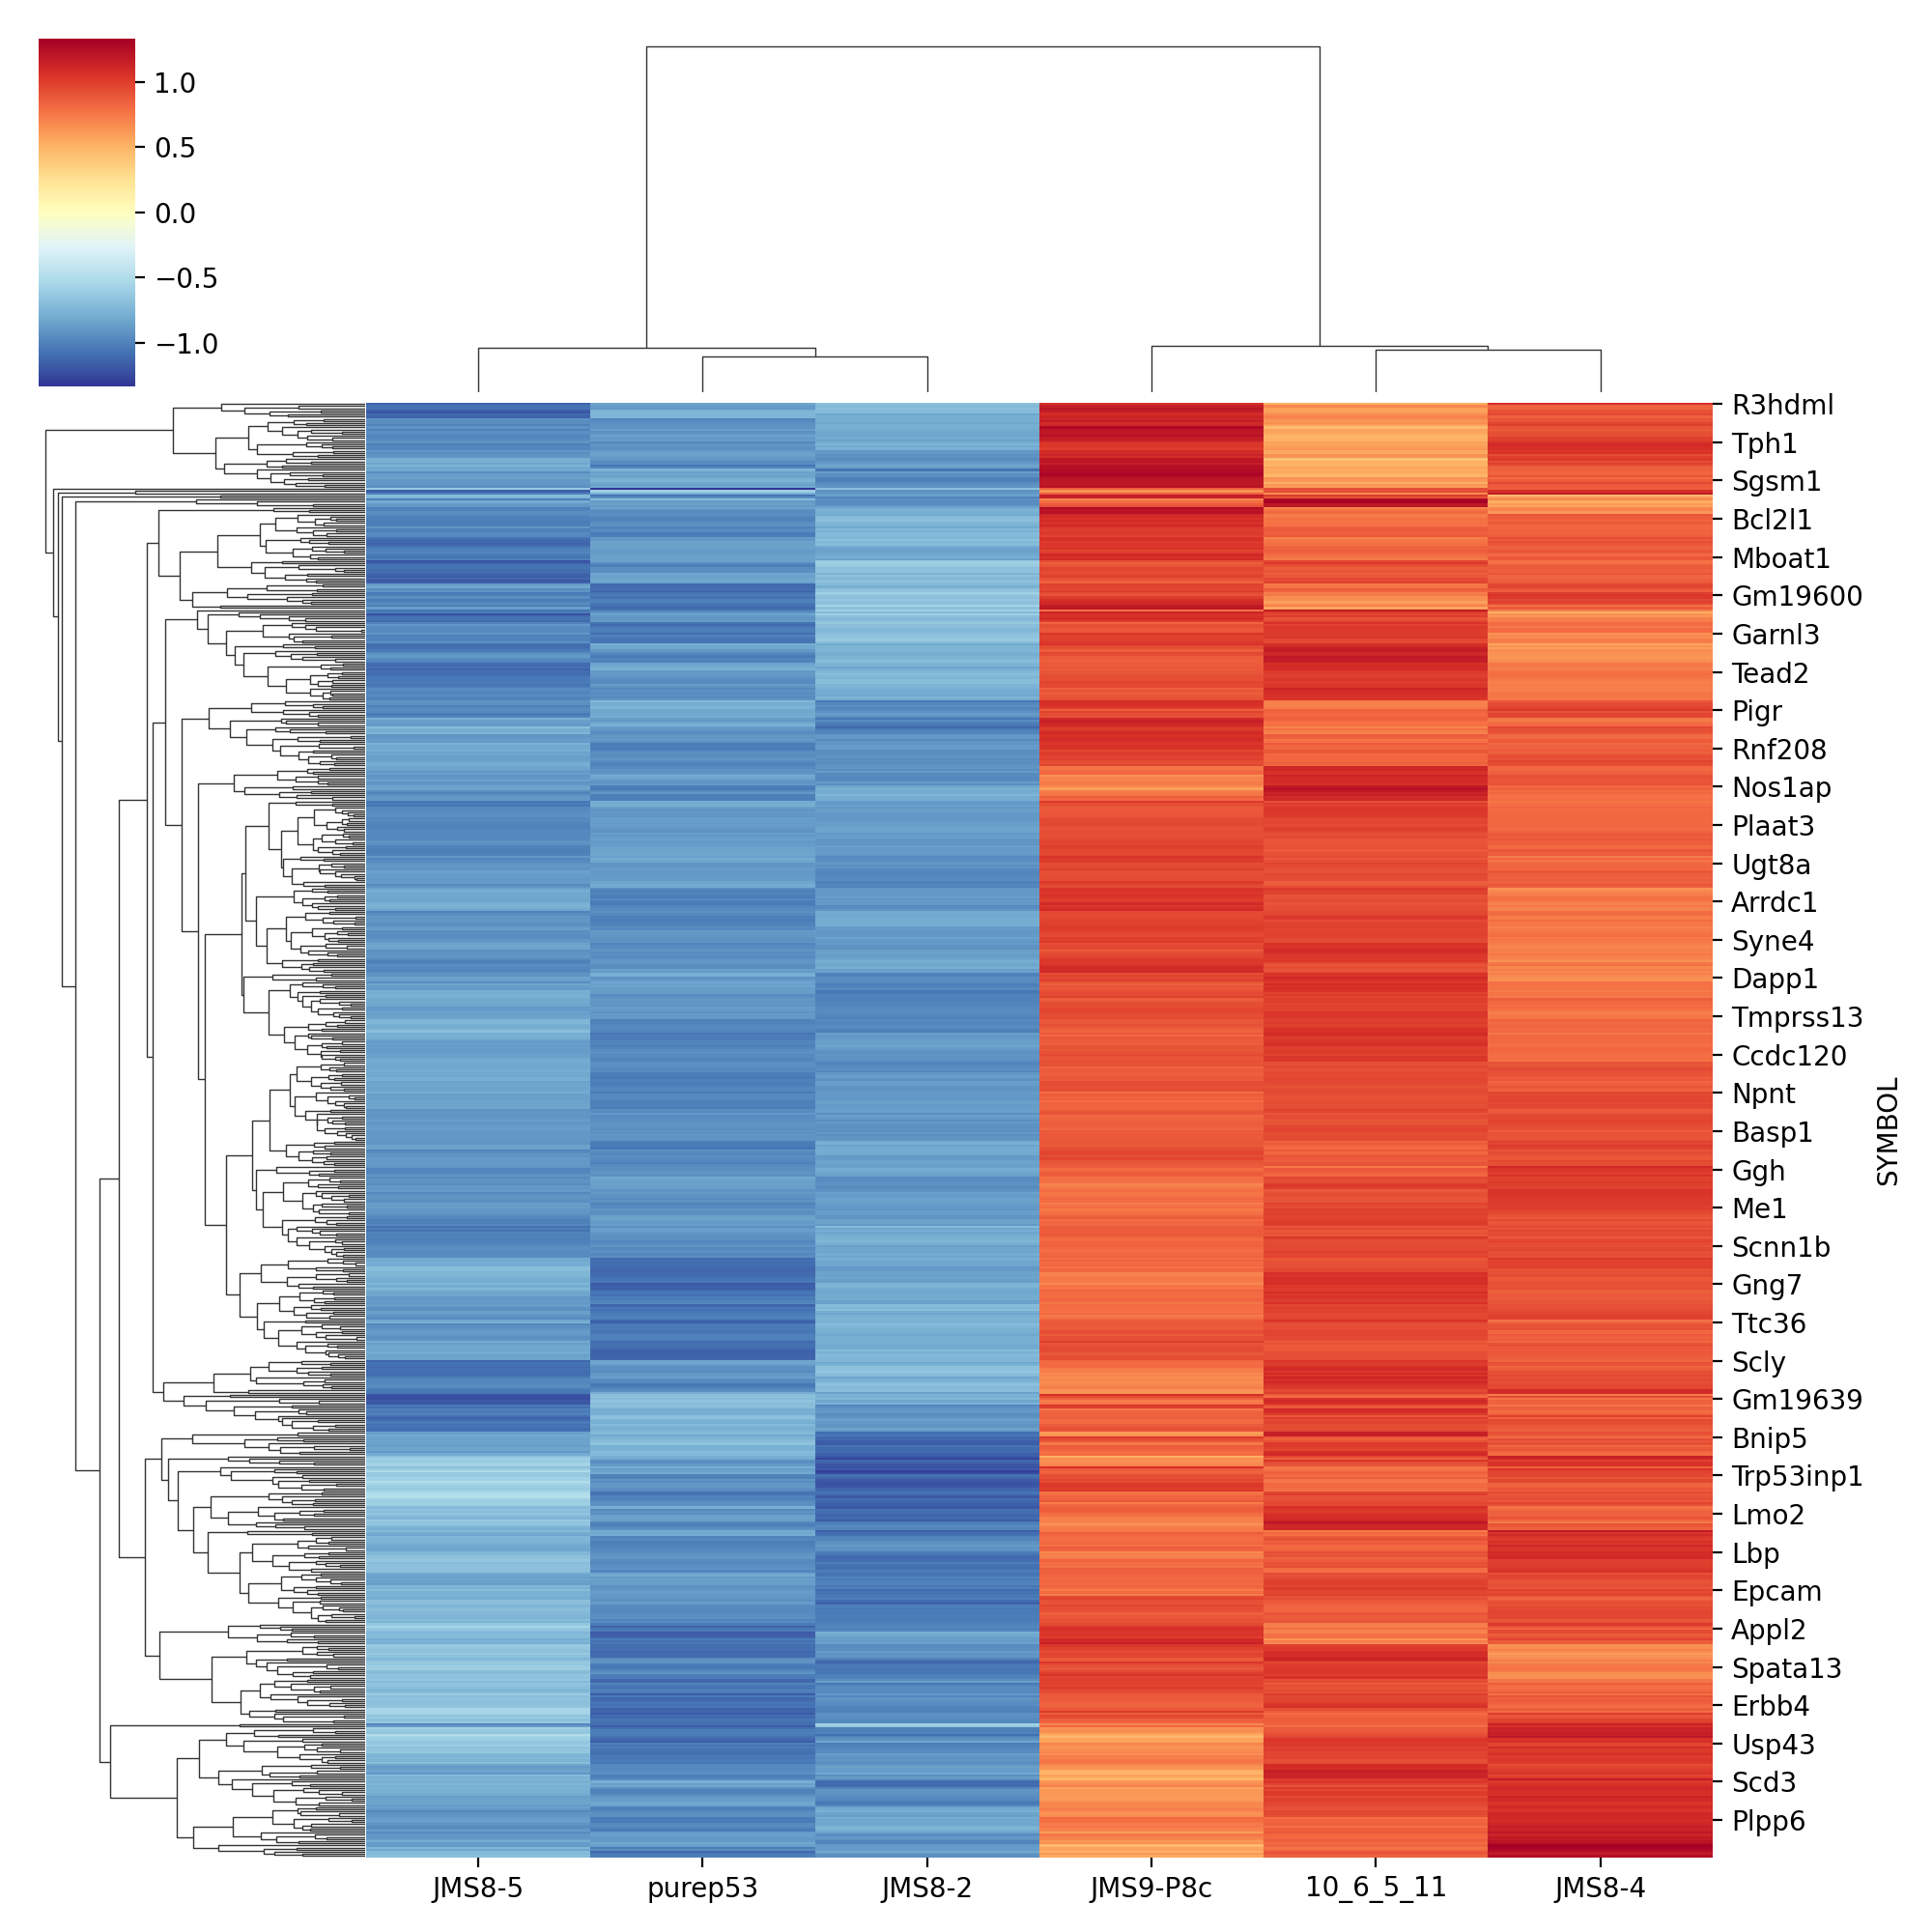

In [45]:
sns.clustermap(plot_data, z_score=0,cmap="RdYlBu_r")
